In [33]:
#import modules

import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
from keras.utils import Sequence
from keras.models import load_model
from tensorflow.distribute import MirroredStrategy

In [34]:
#initialise random generator
rng = np.random.default_rng()

In [35]:
#Define FelixDataflow classes and functions.

class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, file_type):
        """Here self.x is a list of paths to file_type files. self.y is a
        corresponding list of labels."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.file_type = file_type

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return arrs_from_paths(batch_x, self.file_type), to_categorical(np.array(batch_y),10)

def gen_paths_labels(base_path):
    """A generator to yield (data-paths, corresponding labels) tuples for each
    segment of data (typically training, validation, and testing)."""
    for segment in sorted(os.listdir(base_path)):
        segment_path = os.path.join(base_path, segment)
        segment_paths = []
        segment_labels = []
        for label in os.listdir(segment_path):
            label_path = os.path.join(segment_path, label)
            for crystal in os.listdir(label_path):
                segment_paths.append(os.path.join(label_path, crystal))
                segment_labels.append(label)
        indexes = np.arange(len(segment_labels))
        rng.shuffle(indexes)
        yield [np.array(segment_paths)[indexes], np.array(list(map(int,segment_labels)))[indexes]]

def arrs_from_paths(paths, file_type):
    if file_type == "txt":
        return np.array([np.loadtxt(file_name) for file_name in paths])
    elif file_type == "npy":
        #return np.array([np.load(file_name)[[0],:,:] for file_name in paths])
        return np.array([np.load(file_name) for file_name in paths])

  

In [36]:
def felix_fit_new(model, batch_size, epochs, workers, callbacks, AllPaths, file_type, train_history, val_history, patience, test_history, Monitor):
    #AllPaths = [[TrainingPaths, TrainingThickness], [], []]
    """A fit function to allow validation and test data to be supplied via a
    generator."""
    
    best_val_loss = np.inf
    best_val_acc = 0
    
    x = np.arange(0, epochs)
    
    train_seq = FelixSequence(AllPaths[0][0], AllPaths[0][1], batch_size, file_type)
    val_seq = FelixSequence(AllPaths[1][0], AllPaths[1][1], batch_size, file_type)
    test_seq = FelixSequence(AllPaths[2][0], AllPaths[2][1], batch_size, file_type)
    for epoch in range(epochs):
        print("-------------------------------------------------------------------------")
        print("Epoch", epoch+1, "/", epochs, ": ")
        print("Training: ")
        train_hist = model.fit(x = train_seq, epochs = epoch+1, workers = workers, initial_epoch = epoch, shuffle=True)
        train_history[0][epoch] = train_hist.history["loss"][0]
        train_history[1][epoch] = train_hist.history["acc"][0]
        print("Validation: ")
        val_hist = model.evaluate(x = val_seq, workers = workers, callbacks = callbacks)
        #print(val_hist)
        val_history[0][epoch] = val_hist[0]
        val_history[1][epoch] = val_hist[1]
        
        plt.plot(x, val_history[1])
        plt.show()
        
        epoch_loss = val_hist[0]
        epoch_acc = val_hist[1]
        
        
        if(Monitor == "loss"):
            if(epoch_loss < best_val_loss):
                model.save(NewPath+ModelName)
                print("The model loss improved from: ",best_val_loss, "to: ", epoch_loss)
                best_val_loss = epoch_loss
                patience_i = 0
            else:
                patience_i+=1
                print("The model did not improve, patience_i = ", patience_i)

            #val_hist[0][epoch] = avg_recon_loss
            if(patience_i > patience):
                print("Early Stopping, the model did not improve from a loss: ", best_val_loss)
                break
        
        elif(Monitor == "acc"):
            if(best_val_acc < epoch_acc):
                model.save(NewPath+ModelName)
                print("The model accuracy improved from: ",best_val_acc, "to: ", epoch_acc)
                best_val_acc = epoch_acc
                patience_i = 0
            else:
                patience_i+=1
                print("The model accuracy did not improve, patience_i = ", patience_i)

            #val_hist[0][epoch] = avg_recon_loss
            if(patience_i > patience):
                print("Early Stopping, the model did not improve from an accuracy: ", best_val_loss)
                break

    print("-------------------------------------------------------------------------")
    print("Testing: ")
    tst_hist = model.evaluate(test_seq)
    test_history[0] = tst_hist[0]
    test_history[1] = tst_hist[1]



In [44]:
#All paths

SaveDataPath = "/home/ug-ml/Documents/GitHub_BigFiles/SaveFolder" #Base directory of place you store information of models
SaveFolderName = "/Classifer_1_V1" #Will create a folder and put in information about the outcome / inputs
ModelName = "/Model.hdf5"


#Many variables

#Model Variables
input_shape = (1, 128, 128)

#Hyper parameters
learning_rate = 0.0005
l2_regularizer = 0.0001
loss = 'categorical_crossentropy'
optimizer = "RMSprop" #Not a variable ONLY used for a note
batch_size = 16
epochs = 50
ShuffleTrainData = True

#Call back variables
TrainingPatience = 5
CheckPointMonitor = 'val_acc'
EarlyStopMonitor = 'val_acc'

#CPU variables
CPUworkers = 16


#List the name of the variables you want to save in a file
VariableListName = ["input_shape", 
                   "learning_rate", "l2_regularizer", "loss", "optimizer", "batch_size", "epochs", "ShuffleTrainData",
                   "TrainingPatience", "CheckPointMonitor", "EarlyStopMonitor",
                   "CPUworkers"]

#List the variables in the same order as VariableListName
VariableListValues = [input_shape, 
                   learning_rate, l2_regularizer, loss, optimizer, batch_size, epochs, ShuffleTrainData,
                   TrainingPatience, CheckPointMonitor, EarlyStopMonitor,
                   CPUworkers]

In [45]:
#Early stopping and check points

EarlyStop = EarlyStopping(monitor = EarlyStopMonitor,
                          mode = 'min',
                          verbose = 1,
                          patience = TrainingPatience)

NewPath = SaveDataPath + SaveFolderName
Checkpoint = ModelCheckpoint(NewPath + ModelName, #Save path
                             monitor = CheckPointMonitor,
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_freq = 'epoch')


#Make folder to put model and history information
try:
    os.mkdir(NewPath)
except:
    print("Folder failed to be created, it may already exist")
    
File1  = open(NewPath +"/Parameters.txt", "w+")
if(len(VariableListName) == len(VariableListValues)):
    for i in range(0, len(VariableListName)):
        File1.write(VariableListName[i] + " " + str(VariableListValues[i]) + "\n")
    File1.close()
else:
    print("VariableListName and VariableListValues do not match up, so file can not be saved")


In [52]:
#Build model
strategy = MirroredStrategy() #Allows multiple GPUs

with strategy.scope():
    model = models.Sequential()
    model.add(layers.Conv2D(48 * 1, (4, 4),
                                     activation='relu',
                                     data_format='channels_first',
                                     input_shape= input_shape))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Conv2D(48 * 1, (4, 4),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Conv2D(48 * 1, (4, 4),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(48 * 3, activation='relu',
                           kernel_regularizer = l2(l2_regularizer)))
    
    model.add(layers.Dense(10, activation='softmax',
                           kernel_regularizer = l2(l2_regularizer)))

    model.compile(loss = loss,
                  optimizer = optimizers.RMSprop(learning_rate = learning_rate),
                  metrics=['acc'])

#Save summary of model
with open(NewPath + '/summary.txt','w') as fh:
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 48, 125, 125)      816       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 62, 62)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 59, 59)        36912     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 48, 29, 29)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 48, 26, 26)        36912     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4

In [50]:
def MakeThicknessList(ListPaths):
    Thickness = []
    for i in ListPaths:
        Thickness.append(int(i.split("/")[-1].split(".")[0]))
    Thickness = np.array(Thickness)
    return(Thickness)

def OpenTxt(Path):
    with open(Path) as textFile:
        lines = [line.split() for line in textFile]
    List = []
    for i in lines:
        List.append(i[0])
    return(List)

DataPath = "/home/ug-ml/felix-ML/classification/Classification000/DataPaths/"

TrainPath = OpenTxt(DataPath + "Train_0p1.txt")
ValPath = OpenTxt(DataPath + "Validation_0p1.txt")
TestPath = OpenTxt(DataPath + "Test_0p1.txt")

TrainThickness = MakeThicknessList(TrainPath)
ValThickness = MakeThicknessList(ValPath)
TestThickness = MakeThicknessList(TestPath)

AllPaths = [[TrainPath,TrainThickness],[ValPath,ValThickness],[TestPath,TestThickness]]

-------------------------------------------------------------------------
Epoch 1 / 50 : 
Training: 
3537/3537 [==============================] - 78s 22ms/step - loss: 1.7434 - acc: 0.3569
Validation: 
416/416 [==============================] - 10s 23ms/step - loss: 1.5686 - acc: 0.4369


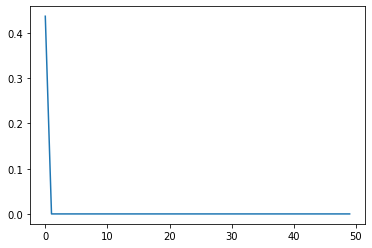

The model accuracy improved from:  0 to:  0.43692678213119507
-------------------------------------------------------------------------
Epoch 2 / 50 : 
Training: 
Epoch 2/2
3537/3537 [==============================] - 78s 22ms/step - loss: 1.4721 - acc: 0.5001
Validation: 
416/416 [==============================] - 10s 24ms/step - loss: 1.3660 - acc: 0.5297


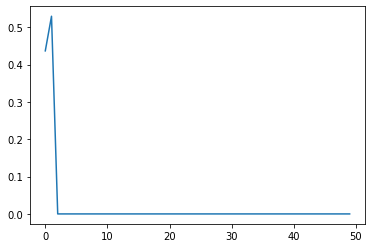

The model accuracy improved from:  0.43692678213119507 to:  0.5296947956085205
-------------------------------------------------------------------------
Epoch 3 / 50 : 
Training: 
Epoch 3/3
3537/3537 [==============================] - ETA: 0s - loss: 1.3194 - acc: 0.564 - 79s 22ms/step - loss: 1.3194 - acc: 0.5648
Validation: 
416/416 [==============================] - 9s 22ms/step - loss: 1.4534 - acc: 0.5339


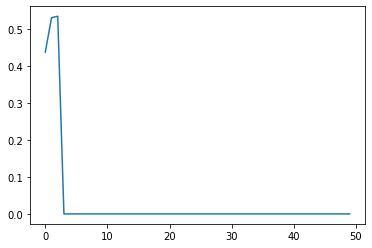

The model accuracy improved from:  0.5296947956085205 to:  0.5339046716690063
-------------------------------------------------------------------------
Epoch 4 / 50 : 
Training: 
Epoch 4/4
 987/3537 [=======>......................] - ETA: 54s - loss: 1.5213 - acc: 0.6033

KeyboardInterrupt: 

In [53]:
training_history = np.zeros(shape=(2,epochs))
validation_history = np.zeros(shape=(2,epochs))
test_history = [0,0]
#print(model.metrics_names)
felix_fit_new(model, batch_size, epochs, CPUworkers, [EarlyStop, Checkpoint], AllPaths, "npy", training_history, validation_history, TrainingPatience, test_history, "acc")

In [43]:
model.save(NewPath+ModelName)
np.save(NewPath+"/training_history.npy", training_history)
np.save(NewPath+"/validation_history.npy", validation_history)